### Important variables 

Deptext = Depression text-response <br> 
Wortext = Worry text-response

dep_all_phraces = Depression all phraces responses <br> 
wor_all_phraces = Worry all phraces responses

dep_all_word = Depression all descriptive word responses <br>
wor_all_words = Worry all descriptive word responses

dep_all_selected1 = All selected depression word responses <br>
wor_all_selected1 = All selected worry word responses

<hr style="border:1px solid gray"> </hr>

CESDtot = Center for Epidemiological Studies Depression (CESD) <br>
PHQtot = PHQ-9 = Patient Helath Questionnaire = a depression scale

GADtot = GAD-7 = Generalized anxiety disorder scale <br>
PSWQtot = Penn State Worry Questionniare 

<hr style="border:1px solid gray"> </hr>

miniGAD_diagnose = Self-reported MINI (structured interview) GAD diangose <br>
minidep_diagnose = Self-reported MINI (structured interview) MDD (depression) diangose

#### Importing and cleaning dataset

In [16]:
import keras
import math
import numpy as np
import os
import pandas as pd
import re
from sklearn import preprocessing

#Get relative directory to find path
path = os.path.join(os.getcwd(), 'data', 'response_format_cleaned_ds1.csv')
responses = pd.read_csv(path, sep=';', header=0)
responses.drop(responses.columns[[0]], axis=1, inplace=True)
responses.head()


,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,sequence1,seqOne,Dep5words[Word1],...,wor_all_selected,wor_all_selected1,minidep_scale,minidep_diagnose,depression_episodes,miniGAD_scale,miniGAD_symptoms_scale,miniGAD_diagnose,minidiagnose_category,minidiagnose_category_number
0,434.0,2020-08-07 11:46:22,15.0,en,6.593644e+08,2020-08-07 11:38:22,2020-08-07 11:46:22,2.0,1.0,motivated,...,NA NA happy NA NA NA NA NA NA NA NA NA NA care...,happy carefree satisfied ...,0.0,0,0,0,0,0,NoDi,0
1,184.0,2020-08-07 11:58:36,15.0,en,2.803892e+08,2020-08-07 11:34:31,2020-08-07 11:58:36,2.0,1.0,connected,...,anxious NA NA NA NA NA NA NA NA NA NA tense NA...,anxious tense fearful sad fe...,3.0,0,0,8,5,0,NoDi,0
2,330.0,2020-08-07 11:51:54,15.0,en,6.770686e+07,2020-08-07 11:36:32,2020-08-07 11:51:54,1.0,1.0,Yes,...,anxious NA NA NA NA NA worried NA NA NA NA NA ...,anxious worried scared sad mon...,7.0,0,5,9,5,0,NoDi,0
3,630.0,2020-08-07 13:22:42,15.0,en,1.176643e+09,2020-08-07 12:55:26,2020-08-07 13:22:42,3.0,1.0,minor,...,anxious NA NA NA NA concerned NA NA NA NA NA t...,anxious concerned tense scared ...,3.0,0,5,8,5,0,NoDi,0
4,400.0,2020-08-07 12:04:52,15.0,en,1.012492e+09,2020-08-07 11:37:19,2020-08-07 12:04:52,1.0,1.0,family,...,NA NA NA NA NA concerned NA NA NA NA NA tense ...,concerned tense sad tired ...,4.0,0,2,7,4,1,GAD,2


### Dataset distribution for: 
#### dep vs. non-dep resonses & anx vs. non-anx responses

In [3]:
print("Count responses with/without diagnosed depression:\n",responses.minidep_diagnose.value_counts())
print("\nCount responses with/without diagnosed anxiety:\n",responses.miniGAD_diagnose.value_counts())

Count responses with/without diagnosed depression:
 0    652
1    324
Name: minidep_diagnose, dtype: int64

Count responses with/without diagnosed anxiety:
 1    499
0    477
Name: miniGAD_diagnose, dtype: int64


#### Importing and cleaning semantic space 

In [4]:
"""
Using 5-gram contexts from the database, a co-occurrence (word by word) matrix was set up, 
where the rows contained the 120,000 most common words in the n-gram database and the columns 
consisted of the 10,000 most common words in the n-gram database.

The variable 'space' is a matrix of the semantic space with dimentions reduced to 512.
"""
path = os.path.join(os.getcwd(), 'data', 'spaceEnglish1.csv')
space = pd.read_csv(path, encoding= 'unicode_escape')
space.set_index('words', inplace=True)
space.drop(space.columns[[0]], axis=1, inplace=True)
space.dropna(inplace=True)
space = space[~space.index.duplicated(keep='first')]

In [5]:
space.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X503,X504,X505,X506,X507,X508,X509,X510,X511,X512
words,,,,,,,,,,,,,,,,,,,,,
was,-0.234071,-0.278211,-0.100658,-0.269570,-0.115498,-0.000038,-0.036835,0.024037,-0.003974,0.006582,...,-0.011414,0.018075,-0.020312,0.001287,0.024483,0.012867,0.021265,0.016368,0.024858,-0.020382
not,-0.283230,-0.338776,-0.141085,-0.243715,-0.236692,-0.033354,-0.099906,0.053253,-0.025582,-0.040372,...,-0.028472,0.048824,-0.025452,0.007828,0.027658,-0.022135,0.023037,0.005371,-0.001482,-0.024063
by,-0.251058,-0.327183,-0.203889,-0.283337,-0.124522,-0.006537,0.015371,0.131667,-0.130597,0.055605,...,-0.001550,0.027915,-0.012646,-0.005019,0.075544,0.014663,0.013489,-0.022636,0.010127,-0.027951
that,-0.281888,-0.346746,-0.171006,-0.266698,-0.208917,-0.019832,-0.035404,0.044301,-0.076601,0.021328,...,0.019319,0.042742,0.001747,0.019198,0.022598,0.034352,0.033282,-0.006843,0.027052,-0.013623
of,-0.256530,-0.335434,-0.229791,-0.256070,-0.120020,0.017080,0.078004,0.112134,-0.073805,0.098183,...,0.012012,0.005470,-0.022383,-0.042172,-0.003430,-0.013435,0.003697,-0.022769,0.024873,0.010061


#### Methods for cleaning and aggregating semantic responses

In [6]:
"""
Cleans the string from punctuations and removes all words which are not represented in the semantic space. 
"""
words_in_space = set(space.index.values)

def clean_text(text):
    if isinstance(text, str):
        try:
            text = text.lower()
            text = re.sub(r'[^\w\s]', '', text)
            text = list(set(text.split()))
            cleaned_words = [w for w in text if w in words_in_space] # TODO: Hantera ord som inte finns i spacet. Nu ignoreras dem.
            return cleaned_words
        except Exception as e: 
            print(e)
    elif math.isnan(text):
        return []

In [7]:
"""
Controlling for artifacts relating to frequently occurring words.

1) Calculate, from Google N-gram, a frequency weighted average of all semantic representations in the space.
   (So that the weighting is proportional to how frequently the words occur in Google N-gram.)
2) Subtract this mean prior to aggregating each word, and then add to the final value.
"""

space_mean = pd.Series.to_numpy(space.mean())

def aggregating_words(responses):
    res_arr = np.zeros(512)
    
    for word in responses:
        word_arr = pd.Series.to_numpy(space.loc[word])
        res_arr = res_arr + (word_arr - space_mean)
    
    res_arr += space_mean    
    res_arr = res_arr / res_arr.sum() # Normalizing aggregated vector
    return res_arr

In [8]:
def aggregate_cell(text):
    words_in_cell = pd.Series.apply(text, clean_text)
    cell_vectors = pd.Series.apply(words_in_cell, aggregating_words)
    return cell_vectors

#### Extracting semantic responses and representing the answer to each question in the semantic space. 

In [9]:
dep_columns = ['Deptext', 'dep_all_phraces', 'dep_all_words', 'dep_all_selected1']
df_dep_responses = responses[dep_columns]

df_dep_aggregated = df_dep_responses.apply(aggregate_cell, axis=1)

In [10]:
wor_columns = ['Wortext', 'wor_all_phraces', 'wor_all_words', 'wor_all_selected1']
df_wor_responses = responses[wor_columns]

df_wor_aggregated = df_wor_responses.apply(aggregate_cell, axis=1)

In [11]:
df_dep_aggregated.iloc[:10]

,Deptext,dep_all_phraces,dep_all_words,dep_all_selected1
0,"[0.14620488346512744, 0.20439917711775293, 0.0...","[-0.7590918166513149, -0.7996448245182234, 0.6...","[-0.1273549613905489, -0.08134255488745973, 0....","[-0.10631367041145831, -0.07611765664843519, 0..."
1,"[0.16873259944807936, 0.22817746128469954, -0....","[0.3150959567419948, 0.4207709520192088, 0.015...","[1.481708549565082, 1.6852794755670626, -1.026...","[-0.4464577452018576, -0.3896723426287449, 0.2..."
2,"[0.1585160316792317, 0.21775160798960103, 0.03...","[0.09205027035822107, 0.12041302636339307, 0.0...","[0.12709153308204263, 0.1429511802002406, -0.0...","[-0.07663349903279251, -0.0006333442681840742,..."
3,"[0.15762474074250954, 0.2167201417841257, 0.02...","[0.27040339683156606, 0.35429957613545465, -0....","[0.025633109762595925, 0.008765453890638984, -...","[-0.07360932328901607, -0.03903701225966792, 0..."
4,"[0.1919698469397766, 0.26635971533780406, 0.01...","[0.399162608260117, 0.46361677244243993, -0.13...","[0.10400074631268066, 0.11652565658484364, -0....","[53.49798528434236, 36.20381427222653, -104.12..."
5,"[0.16020033435596973, 0.22476856909904835, 0.0...","[0.41638292399978516, 0.536890245855951, -0.04...","[-0.026319931002123535, -0.008734687972281292,...","[-0.09433512754889456, -0.049385819397829094, ..."
6,"[0.24168212896922373, 0.3390232477785224, 0.06...","[0.13731923979741942, 0.17728122055888812, 0.0...","[-0.21575673903918435, -0.1725487888622586, 0....","[-0.07639443687669706, -0.06505044300142826, 0..."
7,"[0.19748763475130368, 0.2696508766614912, 0.02...","[0.13360152439614426, 0.18156274220938928, 0.0...","[-0.19561638585825636, -0.14930168873878932, 0...","[0.2828556887611594, 0.25211172678271115, -0.3..."
8,"[0.20163162925816502, 0.2766626351045351, 0.00...","[-0.45676491421319265, -0.17522813017334876, 0...","[-0.13907052976579665, -0.08380077038092036, 0...","[-2.0148557305068016, -1.726843563128263, 3.16..."
9,"[0.1603677930809877, 0.2245635889487624, 0.030...","[0.2313880244576899, 0.31897402139246056, 0.02...","[-0.3710269064624871, -0.3872365612823404, 0.1...","[-0.2317635994266965, -0.2015510492531913, 0.2..."


In [12]:
df_wor_aggregated.iloc[:10]

,Wortext,wor_all_phraces,wor_all_words,wor_all_selected1
0,"[0.14898981572633896, 0.20678471111840985, 0.0...","[0.16848163704578226, 0.21104085954673166, 0.0...","[0.08512889256007854, 0.06930940294720916, -0....","[-0.03628907508059878, -0.028415450913131544, ..."
1,"[0.16658035037273553, 0.22419803669426439, -0....","[2.9261135504830205, 3.7758155740939014, -0.29...","[-0.5054823889786484, -0.1719085052464021, 0.2...","[-0.04345398189988289, -0.02018434198882514, 0..."
2,"[0.1491299748214471, 0.20770588773293344, 0.03...","[0.1066276252125093, 0.12498854698322394, -0.0...","[0.07113400315024146, 0.07405232367513155, -0....","[-0.24450141879414847, -0.12076884155682276, 0..."
3,"[0.14166991480328248, 0.19702991519885338, 0.0...","[-0.2093961036417864, -0.02262574654514591, 0....","[-0.06529720047146943, 0.046267332309030004, 0...","[-0.1487217599810067, -0.09152232772736167, 0...."
4,"[0.1867096354427329, 0.2567653702853522, 0.023...","[0.268473440352966, 0.3316357580608249, 0.0003...","[-0.08879341781163713, -0.0742497412666487, 0....","[-0.06327165709289427, -0.04194209704023101, 0..."
5,"[0.2411979563481076, 0.33238598874360764, 0.03...","[0.46890125346292594, 0.5876218339044472, -0.0...","[-0.30424776300405115, -0.04949671606636574, 0...","[-0.041991902728896593, -0.02405995612369255, ..."
6,"[0.24362128776903585, 0.33632868049223213, 0.0...","[0.14751288417729552, 0.19693854765932106, 0.0...","[0.11098324236286274, 0.036409039030220726, -0...","[0.3334432322058589, 0.26953732272642683, -0.2..."
7,"[0.16857844964441274, 0.23540663423371674, 0.0...","[0.15824374599203708, 0.20497218134088438, -0....","[-0.26178040246623885, 0.0072036817623368655, ...","[0.06378269752602983, 0.008016117756634659, -0..."
8,"[0.18522021167783892, 0.2544669083751668, 0.00...","[0.11635905622328904, 0.018585133221237254, -0...","[0.06984923510555659, 0.006518063912136106, -0...","[0.08754686825446148, 0.06462605258728954, -0...."
9,"[0.20460668328382742, 0.2821164677632141, 0.02...","[0.17554926424116063, 0.2157095366202667, -0.0...","[-0.1030567815711934, -0.046450255936402354, 0...","[-0.31795743940750393, -0.17534088139707663, 0..."


In [17]:
def concat_vectors(row):
    return np.concatenate(row.values).ravel()

df_dep_concat = pd.DataFrame(preprocessing.normalize(list(df_dep_aggregated.apply(concat_vectors, axis=1)), norm='l2'))
df_wor_concat = pd.DataFrame(preprocessing.normalize(list(df_wor_aggregated.apply(concat_vectors, axis=1)), norm='l2'))

### Concatinating the semantic representations for each question into one multidimensional response vector
Each participant's semantic responses are now represented by two 2048 dimension vectors. 
One for depression-words and one for anxiety-words

In [18]:
df_wor_concat.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.109496,0.151971,0.017082,0.082894,0.054804,-0.006505,0.010062,-0.031879,0.010895,-0.006186,...,0.006952,0.002008,-0.026308,0.014621,0.001987,0.008567,0.021400,0.018136,0.035397,-0.007536
1,0.011654,0.015685,-0.000312,0.007957,0.006109,-0.000288,0.000767,-0.000759,0.001302,-0.000442,...,0.002868,0.002168,0.004384,0.001741,0.000888,0.001848,-0.001369,-0.000664,-0.000712,0.002002
2,0.049035,0.068295,0.010742,0.031065,0.025896,-0.001962,0.010025,-0.012665,0.007208,-0.008150,...,0.062382,0.074305,-0.001598,0.011123,-0.019827,0.010773,0.019781,0.029106,-0.032195,0.024699
3,0.028100,0.039080,0.005573,0.018504,0.015643,-0.002012,0.005148,-0.007980,0.003354,-0.001259,...,0.010834,0.010143,0.015765,-0.011890,-0.013041,0.026642,-0.003386,0.004708,0.013604,0.008092
4,0.126596,0.174096,0.015696,0.080609,0.066885,-0.012112,0.015176,-0.026336,0.009358,-0.015648,...,-0.019228,0.039447,0.008304,-0.018615,-0.024036,0.002641,-0.005707,0.005444,0.002030,0.028183


#### Performing principal component analysis to reduce the number of dimensions for the concatinated semantic vectors

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def reduce_dim(k, X_dep=df_dep_concat.values, X_wor=df_wor_concat.values):
    #Perform PCA and return dataframes for dep and anx
    pca = PCA(n_components=k)
    pca_vector_dep = pca.fit_transform(X_dep)
    pca_vector_wor = pca.fit_transform(X_wor)

    response_space_dep = pd.DataFrame(data = pca_vector_dep)
    response_space_wor = pd.DataFrame(data = pca_vector_wor)
    return response_space_dep, response_space_wor

In [20]:
response_space_dep, response_space_wor = reduce_dim(74)
response_space_dep.head()

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,0.079707,0.476504,0.217473,-0.118780,-0.043407,0.032801,0.002998,0.071037,0.033630,0.136544,...,0.079005,0.095997,-0.066377,-0.034110,0.035189,-0.028425,0.034610,-0.015509,0.004410,0.118376
1,0.054734,-0.140480,0.193777,-0.163228,0.049073,0.068481,0.201238,0.084731,-0.073477,-0.167831,...,0.117252,-0.036026,0.119203,0.013424,-0.084848,0.006593,0.068108,0.038882,-0.051439,0.048370
2,-0.430039,-0.128266,0.123441,0.080880,-0.178452,-0.298172,-0.014014,0.009909,-0.007385,0.070247,...,0.018566,0.087358,-0.051399,0.031901,0.017758,-0.028356,0.021652,-0.079356,0.028327,-0.023889
3,-0.317460,-0.381528,-0.076944,0.114936,-0.260949,-0.109800,-0.058466,-0.255348,-0.034036,-0.046369,...,-0.031981,-0.006602,-0.018992,0.041669,0.003809,0.008793,0.019507,-0.003216,0.017466,0.010918
4,0.944212,-0.004064,0.070093,0.223812,-0.445372,-0.085786,0.219685,-0.004654,0.007910,-0.021725,...,0.001404,-0.002797,0.005082,-0.000433,-0.000785,-0.001629,-0.003917,-0.004314,0.002084,0.001857


# Dimension Reduction and plotting of features vs. PHQ/GAD scale

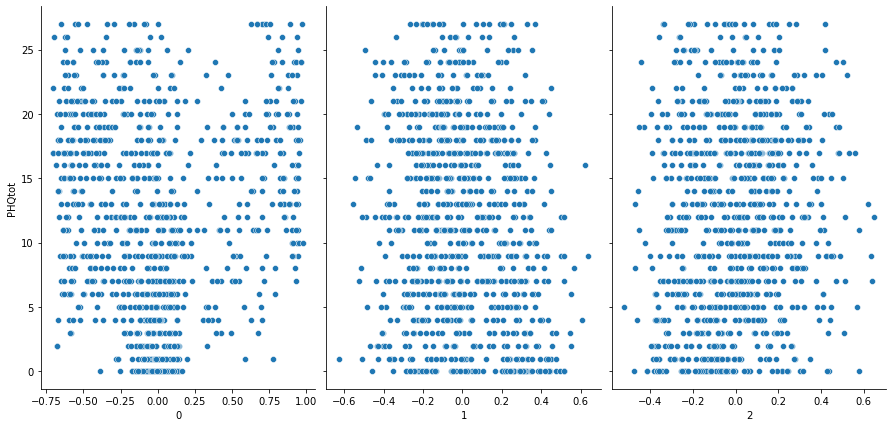

In [22]:
df_plot_dep, df_plot_wor = reduce_dim(3)
df_plot_dep.columns = ['0', '1', '2']
df_plot_wor.columns = ['0', '1', '2']

df_plot_dep['PHQtot'] = responses.PHQtot
df_plot_wor['GADtot'] = responses.GADtot

sns.pairplot(df_plot_dep, x_vars=['0', '1', '2'], y_vars='PHQtot', height=6, aspect=0.7)#, hue=list(df_plot_dep.minidep_diagnose))

# Using the Semantic Representations in Analyses

### The dependent variable for worry and depression

In [24]:
"""
Semantic-numeric correlations. 
Analyzing the relationship between semantic responses and a numerical variable
"""
 
#The numerical rating scales for depression and worry
dep_scale = responses[['PHQtot']]
wor_scale = responses[['GADtot']]

#Checking for NaN values
dep_scale.isnull().values.any() #true
wor_scale.isnull().values.any() #true

def replace_nan(y_array):
    #Replaceing NaN values with mean value of column - perhaps we should do this differently
    col_mean = np.nanmean(y_array, axis=0)
    col_mean = np.around(col_mean, decimals=0, out=None) 
    inds = np.where(np.isnan(y_array))
    y_array[inds] = np.take(col_mean, inds[1])
    return y_array

#Create y - variables
y_wor_scale = wor_scale.values
y_dep_scale = dep_scale.values

#Replace NaN Values for the numerical scales
y_wor_scale = replace_nan(y_wor_scale).flatten()
y_dep_scale = replace_nan(y_dep_scale).flatten()

In [25]:
#The categorical variables, whether someone is diagnosed with worry/dep or not
dep_diag = responses[['minidep_diagnose']]
wor_diag = responses[['miniGAD_diagnose']]

print("Respondents with diagnose: {} out of {}".format(int(dep_diag.sum()), len(dep_diag))) #unbalanced
print("Respondents with diagnose: {} out of {}".format(int(wor_diag.sum()), len(wor_diag))) #not as unbalanced

#Checking for NaN values
dep_diag.isnull().values.any() #false
wor_diag.isnull().values.any() #false

#Create y - variables
y_wor_diag = wor_diag.values
y_dep_diag = dep_diag.values

Respondents with diagnose: 324 out of 976
Respondents with diagnose: 499 out of 976


Import packages needed for analysis

In [26]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

## Analysis using plain linear regression and numerical scales as dependent variable 

### Depression

In [27]:
"""Predicting the corresponding numeric rating scales on the basis of these representations by means 
of multiple linear regression analyses """

#x_dep = df_dep_concat #To use full concatinated vectors with 2048 dimensions (before PCA) + normalized with l2
x_dep =  reduce_dim(56)[0] #To use vectors with reduced dimensions (after PCA)

X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(x_dep, y_dep_scale, test_size=0.2, random_state=0)

regr_dep = LinearRegression().fit(X_train_dep, y_train_dep)
y_pred_dep = regr_dep.predict(X_test_dep) 

In [30]:
print("R2 score for training data:  ", regr_dep.score(X_train_dep, y_train_dep)) #R2 score for training data is 0.8
print("R2 score for testing data:  ", regr_dep.score(X_test_dep, y_test_dep)) #R2 score for test data is -223.13 
print("\nRoot Mean Squared Error (RMSE):  ", np.sqrt(metrics.mean_squared_error(y_test_dep, y_pred_dep)))
#print("Intercept:  ", regr_dep.intercept_)
print("Median absolute error for test data: ", median_absolute_error(y_pred_dep, y_test_dep))
print("Median absolute error for training data: ", median_absolute_error(regr_dep.predict(X_train_dep), y_train_dep))

R2 score for training data:   0.3709143312173716
R2 score for testing data:   0.21900623305899047

Root Mean Squared Error (RMSE):   6.491877206643204
Median absolute error for test data:  4.503826055928018
Median absolute error for training data:  3.9455071314124153


In [ ]:
y_train_dep=y_train_dep.ravel()
log_dep = LogisticRegression().fit(X_train_dep, y_train_dep)

# Predicting the test set results
y_pred_dep = log_wor.predict(X_test_dep)

##TODO: Make sure the dataset is balanced

In [ ]:
print("R2 score for dep training data:  ", log_wor.score(X_train_dep, y_train_dep)) 
print("R2 score for dep testing data:  ", log_wor.score(X_test_dep, y_test_dep)) 

#R2 score for dep training data:   0.5923076923076923
#R2 score for dep testing data:   0.5969387755102041

#### Worry

In [31]:
"""Predicting the diagnosis on the basis of the representations by means 
of logistic regression """

#x_wor = df_wor_concat #To use full concatinated vectors with 2048 dimensions (before PCA) + normalized with l2
x_wor = reduce_dim(74)[1] #To use vectors with reduced dimensions (after PCA)

X_train_wor, X_test_wor, y_train_wor, y_test_wor = train_test_split(x_wor, y_wor_scale, test_size=0.2, random_state=0)

regr_wor = LinearRegression()
regr_wor.fit(X_train_wor, y_train_wor)

y_pred_wor = regr_wor.predict(X_test_wor)

In [32]:
print("R2 score for worry training data:  ", regr_wor.score(X_train_wor, y_train_wor)) #R2 score for training data is 0.7 is 0.67
print("R2 score for worry testing data:  ", regr_wor.score(X_test_wor, y_test_wor)) #R2 score for test data is -3
print("\nRoot Mean Squared Error (RMSE):  ", np.sqrt(mean_squared_error(y_test_wor, y_pred_wor)))
#print("Intercept:  ", regr_wor.intercept_)
print("Median absolute error for test data: ", median_absolute_error(y_pred_wor, y_test_wor))
print("Median absolute error for training data: ", median_absolute_error(regr_wor.predict(X_train_wor), y_train_wor))

#print(regr.coef_)

R2 score for worry training data:   0.24223132471506403
R2 score for worry testing data:   0.19686419174293546

Root Mean Squared Error (RMSE):   5.388759042764985
Median absolute error for test data:  4.061403998978311
Median absolute error for training data:  4.075542064782295


In [ ]:
y_train_wor=y_train_wor.ravel()

log_wor = LogisticRegression().fit(X_train_wor, y_train_wor)

# Predicting the test set results
y_pred_wor = log_wor.predict(X_test_wor)

In [ ]:
print("R2 score for worry training data:  ", log_wor.score(X_train_wor, y_train_wor)) 
print("R2 score for worry testing data:  ", log_wor.score(X_test_wor, y_test_wor))

#R2 score for worry training data:   0.7589743589743589
#R2 score for worry testing data:   0.6581632653061225

# Examining optimal number of dimensions
### Using the method described in the article combined with plain linear regression

In [ ]:
"""In practice, this was simply achieved by adding 1, 
then multiplying by 1.3 and finally rounding to the nearest integer 
(e.g., 1, 3, 5, 8, where the next number of dimen- sions to be tested are the first 12; 
in other words ([8 􏰃 1] 􏰍 1.3).
In previous research, we have found this sequence to be valid and computationally efficient"""


In [ ]:
#initializing values
n, min_err = 1, np.inf
new_x = df_wor_concat

# df_wor_concat => To use full concatinated vectors with 2048 dimensions (before PCA)
# response_space_wor => To use vectors with reduced dimensions (after PCA)


while n < len(df_wor_concat.columns):
    
    #split data into train and test data
    X_train_wor, X_test_wor, y_train_wor, y_test_wor = train_test_split(new_x, y_wor, test_size=0.2, random_state=0)
    y_train_wor = y_train_wor.flatten() 
    y_test_wor = y_test_wor.flatten()
    
    regr_wor = LinearRegression()
    
    #fit data
    regr_wor.fit(X_train_wor, y_train_wor)
    
    #make prediction 
    y_pred_wor = regr_wor.predict(X_test_wor) 
    
    #test prediction with mean squared error 
    err = mean_squared_error(y_test_wor, y_pred_wor)
    
    #compare err with current min err to then later choose the nbr of dimensions that give minimum mean squared error
    if err < min_err:
        min_err = err
        dimensions = n
        r2 = regr_wor.score(X_test_wor, y_test_wor)
        
    n=round((n+1)*1.3)
    new_x=df_wor_concat.iloc[:,:n] 

print('Nbr of dimensions to use : ', dimensions) #According to this we should use 98 dimensions in the next steps?
print(min_err)
print(r2)

In [ ]:
"Using the depression data to test how many dimensions to keep"

y_dim = y_dep
dimension, min_error = 0, np.inf
i = 1

# df_wor_concat => To use full concatinated vectors with 2048 dimensions (before PCA)
# response_space_wor => To use vectors with reduced dimensions (after PCA)

while i < len(df_dep_concat.columns):
    x_dim = df_dep_concat.iloc[:,:i]
    X_train_dim, X_test_dim, y_train_dim, y_test_dim = train_test_split(x_dim, y_dim, test_size=0.2, random_state=0)

    regr_dim = LinearRegression()
    
    regr_dim.fit(X_train_dim, y_train_dim)
    y_pred_dim = regr_dim.predict(X_test_dim) 
    
    mse = mean_squared_error(y_test_dim, y_pred_dim)
    
    if mse < min_error: 
        min_error = mse
        dimension = i
        r2 = regr_dim.score(X_test_dim, y_test_dim)
    #print(i, mse)
    i = round((i + 1)*1.3)
    
print('\nNbr of dimensions to use: ', dimension)
print(min_error, r2)



# Results examining optimal number of dimensions

#### Depression

Technique | Original dimension | R2 score | MSE | Nbr dimensions
----- | --- | --- | --- | --- 
**(i+1)*1.3** from article w/ **linReg** | PCA red vec: 512 | 0.040 | 51.80 | 17
**(i+1)*1.3** from article w/ **linReg** | Full concat: 2048	 | 0.136 | 46.62 | 56
**(i+1)*1.3** from article w/ **leave 10% CV** | Full concat: 2048 | -0.025 | 6.828 | 74



#### Anxiety

Technique | Original dimension | R2 score | MSE | Nbr dimensions
----- | --- | --- | --- | --- 
**(i+1)*1.3** from article w/ **linReg** | PCA red vec: 512 | 0.131 | 31.42 | 56
**(i+1)*1.3** from article w/ **linReg** | Full concat: 2048 | 0.131 | 31.42 | 98
**(i+1)*1.3** from article w/ **leave 10% CV** | Full concat: 2048 | -0.112 | 7.169 | 56


# Cross validation techniques

## Examining optimal number of dimensions using method described in article combined with leave 10% cross validation

### Depression

In [ ]:
#Leave 10% out cross validation while testing the number of dimensions that will give the best over all score. 

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

nbr_folds = round(len(responses)*0.1)
cv = KFold(n_splits=nbr_folds, random_state=1, shuffle=True)

reg = LinearRegression()
dimension, min_error = 0, -np.inf
i = 1

#df_dep_concat      => To use full concatinated vectors with 2048 dimensions (before PCA)
#response_space_dep => To use vectors with reduced dimensions (after PCA)

while i < len(df_dep_concat.columns):
    x_dep_cv = df_dep_concat.iloc[:,:i]
    
    #Options for scoring: 'r2', 'neg_root_mean_squared_error' 
    scores = cross_val_score(reg, x_dep_cv, y_dep, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    
    if scores.mean() > min_error:
        min_error = scores.mean()
        dimension = i
        
    i = round((i + 1)*1.3)
    
print("Best score: {} with dimension: {}".format(min_error, dimension)) #Using dep data => 74 dimensions

### Anxiety

In [ ]:
#Leave 10% out cross validation while testing the number of dimensions that will give the best over all score. 

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

nbr_folds = round(len(responses)*0.1)
cv = KFold(n_splits=nbr_folds, random_state=1, shuffle=True)

reg = LinearRegression()
dimension, min_error = 0, -np.inf
i = 1

#df_wor_concat      => To use full concatinated vectors with 2048 dimensions (before PCA)
#response_space_wor => To use vectors with reduced dimensions (after PCA)

while i < len(df_wor_concat.columns):
    x_wor_cv = df_wor_concat.iloc[:,:i]
    
    #Options for scoring: 'r2', 'neg_root_mean_squared_error' 
    scores = cross_val_score(reg, x_wor_cv, y_dep, scoring='r2', cv=cv, n_jobs=-1)
    
    if scores.mean() > min_error:
        min_error = scores.mean()
        dimension = i
        
    i = round((i + 1)*1.3)
    
print("Best score: {} with dimension: {}".format(min_error, dimension)) #Using wor data => 56 dimensions

#### Leave 10% out cross validation on PCA reduced vectors

In [ ]:
#Leave 10% out cross validation using PCA reduced vectors

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

nbr_folds = round(len(responses)*0.1)
cv = KFold(n_splits=nbr_folds, random_state=1, shuffle=True)

reg = LinearRegression()

#df_dep_concat      => To use full concatinated vectors with 2048 dimensions (before PCA)
x_dep_cv = response_space_dep #=> To use vectors with reduced dimensions (after PCA)

#Options for scoring: 'r2', 'neg_root_mean_squared_error' 
scores = cross_val_score(reg, x_dep_cv, y_dep, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
print(scores.mean())

# Visualisation

In [33]:
import seaborn as sns
import umap
#%matplotlib inline

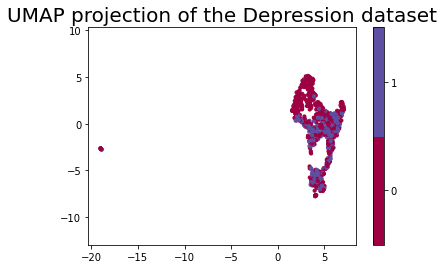

In [46]:
"""Will use umap by: constructing a model, training the model, and then looking at the transformed data"""

reducer = umap.UMAP()

#embedding = reducer.fit_transform(reduce_dim(56)[0]) #uses vectors with reduced dimensions (after PCA)
embedding = reducer.fit_transform(df_dep_concat) #uses full concatinated vectors with 2048 dimensions (before PCA)

#plot the embedding as a standard scatterplot and color by the target array
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_dep_diag, cmap='Spectral', s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.title('UMAP projection of the Depression dataset', fontsize=20);

In [ ]:
# Build and plot PCA to visualize the balance of the classes in the dataset
pca = PCA(n_components=2)
pca.fit(np.array(X_train_dep))
X_pca_dep = pca.transform(np.array(X_train_dep))
plt.scatter(X_pca_dep[:, 0], X_pca_dep[:, 1], c=y_train_dep, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()
#the PCA plot shows that the red class (diagnosed) is mostly represented 

In [ ]:
# build and plot PCA to visualize the balance of the classes in the dataset
pca = PCA(n_components=2)
pca.fit(np.array(X_train_wor))
X_pca_wor = pca.transform(np.array(X_train_wor))
plt.scatter(X_pca_wor[:, 0], X_pca_wor[:, 1], c=y_train_wor, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()